In [42]:
import pandas as pd
import numpy as np
import yaml
import sys
import warnings

import plotter as plot
import matplotlib.pyplot as plt

from pathlib import Path

from Stocks import Stock
from Portfolio import Portfolio
import distributions as dt
import returns as rt
import financial_ratios as fr
import optimizers as opt
import numpy as np
import prophet_helpers as ph
import timestamps as ts
import seaborn as sns


import scipy.stats as stats
from prophet import Prophet


warnings.simplefilter(action='ignore')

def read_yaml(file_name): 
    with open(file_name) as file:
        yaml_data= yaml.safe_load(file)
    return yaml_data

config = read_yaml('config.yaml')
# config['canadian_etfs_parsed']
canadian_etfs_parsed = config['canadian_etfs_parsed']
canadian_etfs_parsed



['VFV.TO']

<img src="Dataset_info.png" alt="Screenshot" width="800" height='400'/>

# Data Loading 

In [43]:
start_dt = '2011-01-03'
end_dt= '2015-04-13'
training_start_dt = '2011-01-03'
training_end_dt = '2012-12-31'

test_start_dt = '2013-01-02' 
test_end_dt = '2013-12-31'

out_of_sample_start_dt = '2014-01-02'
out_of_sample_end_dt = '2015-04-13'
tickers=[ 'DIA', 'QQQ', 'SPY' ]

dia_df = Stock('DIA', start_dt, end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY',start_dt, end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', start_dt, end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [44]:
dia_df.ticker_data.head()

,Open,High,Low,Close,Volume,ticker,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
2011-01-03,116.410004,116.860001,116.360001,116.410004,9108900,DIA,NaN,0.000000,0.131682,0.131682,0.000000,0.000000,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-04,116.709999,116.730003,116.110001,116.639999,9775600,DIA,0.001976,0.197574,0.134696,0.133189,0.000002,0.001507,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-05,116.459999,117.190002,116.300003,117.040001,7567800,DIA,0.003429,0.541188,0.139937,0.135439,0.000012,0.003411,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-06,117.139999,117.190002,116.500000,116.779999,7161600,DIA,-0.002221,0.317838,0.136530,0.135711,0.000009,0.002991,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-07,116.910004,117.099998,115.820000,116.570000,9249800,DIA,-0.001798,0.137442,0.133779,0.135325,0.000008,0.002785,-0.426358,4.152463,804.160704,2.391784e-175


# Portfolio Creation and Summary Statistics

In [45]:
p = Portfolio(tickers=[ 'DIA', 'QQQ', 'SPY' ], start_dt=start_dt, end_dt=end_dt)
cm = sns.light_palette("green", as_cmap=True) 
p.summary_statistics.style.background_gradient(cmap=cm)

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


,ticker,mean,variance,skewness,kurtosis,VaR,cVaR
0,DIA,0.000448,0.000078,-0.426358,4.152463,-0.014124,-0.021020
1,QQQ,0.000677,0.000111,-0.319222,3.023044,-0.016630,-0.024192
2,SPY,0.000515,0.000092,-0.453330,4.917879,-0.015261,-0.022763


In [46]:
p.correlation_matrix.style.background_gradient(cmap=cm)

,DIA,QQQ,SPY
DIA,1.000000,0.871865,0.971892
QQQ,0.871865,1.000000,0.926446
SPY,0.971892,0.926446,1.000000


In [47]:
df = p.all_stocks_df.copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,ticker,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
2011-01-03,116.410004,116.860001,116.360001,116.410004,9108900,DIA,NaN,0.000000,0.131682,0.131682,0.000000,0.000000,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-04,116.709999,116.730003,116.110001,116.639999,9775600,DIA,0.001976,0.197574,0.134696,0.133189,0.000002,0.001507,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-05,116.459999,117.190002,116.300003,117.040001,7567800,DIA,0.003429,0.541188,0.139937,0.135439,0.000012,0.003411,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-06,117.139999,117.190002,116.500000,116.779999,7161600,DIA,-0.002221,0.317838,0.136530,0.135711,0.000009,0.002991,-0.426358,4.152463,804.160704,2.391784e-175
2011-01-07,116.910004,117.099998,115.820000,116.570000,9249800,DIA,-0.001798,0.137442,0.133779,0.135325,0.000008,0.002785,-0.426358,4.152463,804.160704,2.391784e-175


### Generate Combinations 

In [48]:
def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations

combinations = generate_combinations()
print(combinations)

combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df


[(0.0, 0.0, 1.0), (0.0, 0.2, 0.8), (0.0, 0.4, 0.6), (0.0, 0.6, 0.4), (0.0, 0.8, 0.2), (0.0, 1.0, 0.0), (0.2, 0.0, 0.8), (0.2, 0.2, 0.6), (0.2, 0.4, 0.4), (0.2, 0.6, 0.2), (0.2, 0.8, 0.0), (0.4, 0.0, 0.6), (0.4, 0.2, 0.4), (0.4, 0.4, 0.2), (0.4, 0.6, 0.0), (0.6, 0.0, 0.4), (0.6, 0.2, 0.2), (0.6, 0.4, 0.0), (0.8, 0.0, 0.2), (0.8, 0.2, 0.0), (1.0, 0.0, 0.0)]


,DIA,QQQ,SPY
0,0.0,0.0,1.0
1,0.0,0.2,0.8
2,0.0,0.4,0.6
3,0.0,0.6,0.4
4,0.0,0.8,0.2
5,0.0,1.0,0.0
6,0.2,0.0,0.8
7,0.2,0.2,0.6
8,0.2,0.4,0.4
9,0.2,0.6,0.2


In [49]:
initial_budget =10000

def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

In [50]:
tickers=[ 'DIA', 'QQQ', 'SPY' ]
dfs = [dia_df.ticker_data,spy_df.ticker_data, qqq_df.ticker_data]

def merge_dfs(dfs): 

    merged_df = dfs[0].copy(deep=True)
    ticker = merged_df['ticker'].iloc[0]
    merged_df.rename(columns={'Close':f'Close_{ticker}'}, inplace=True)

    for i in range(1,len(dfs)): 
        temp_df =dfs[i].copy(deep=True)
        temp_ticker = temp_df['ticker'].iloc[0]
        temp_df.rename(columns={'Close':f'Close_{temp_ticker}'}, inplace=True)


        merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True)
        
    return merged_df 
    
merged_df =merge_dfs(dfs)
merged_df.head()

,Open_x,High_x,Low_x,Close_DIA,Volume_x,ticker_x,pct_change_x,Cumulative_Percentage_Change_x,normalized_close_x,cumulative_mean_normalized_close_x,...,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
2011-01-03,116.410004,116.860001,116.360001,116.410004,9108900,DIA,NaN,0.000000,0.131682,0.131682,...,NaN,0.000000,0.088964,0.088964,0.000000e+00,0.000000,-0.319222,3.023044,427.201569,1.715371e-93
2011-01-04,116.709999,116.730003,116.110001,116.639999,9775600,DIA,0.001976,0.197574,0.134696,0.133189,...,-0.000723,-0.072321,0.088290,0.088627,1.135634e-07,0.000337,-0.319222,3.023044,427.201569,1.715371e-93
2011-01-05,116.459999,117.190002,116.300003,117.040001,7567800,DIA,0.003429,0.541188,0.139937,0.135439,...,0.008504,0.777437,0.096209,0.091154,1.285105e-05,0.003585,-0.319222,3.023044,427.201569,1.715371e-93
2011-01-06,117.139999,117.190002,116.500000,116.779999,7161600,DIA,-0.002221,0.317838,0.136530,0.135711,...,0.003229,1.102869,0.099242,0.093176,2.190242e-05,0.004680,-0.319222,3.023044,427.201569,1.715371e-93
2011-01-07,116.910004,117.099998,115.820000,116.570000,9249800,DIA,-0.001798,0.137442,0.133779,0.135325,...,-0.000894,1.012471,0.098399,0.094221,2.188707e-05,0.004678,-0.319222,3.023044,427.201569,1.715371e-93


In [51]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer


class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, changepoint_prior_scale=0.05, seasonality_mode='additive', seasonality_prior_scale=10.0, daily_seasonality=False):
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.daily_seasonality = daily_seasonality
        
    def fit(self, X, y):
        self.model = Prophet(changepoint_prior_scale=self.changepoint_prior_scale,
                             seasonality_mode=self.seasonality_mode,
                             seasonality_prior_scale=self.seasonality_prior_scale,
                             daily_seasonality=self.daily_seasonality)
        self.model.fit(pd.concat([X, y], axis=1))
        return self
    
    def predict(self, X):
        forecast = self.model.predict(X)
        return forecast['yhat'].values

    
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [1.0, 10.0, 20.0],
}


tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=ProphetWrapper(),
    param_grid=param_grid,
    cv=tscv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
)

dia_df.ticker_data.reset_index(inplace=True)
data = dia_df.ticker_data
data = data[['index', 'Close']]
data.columns = ['ds', 'y']

X = data['ds'].to_frame()
y = data['y'].to_frame()

grid_search.fit(X, y)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ProphetWrapper(), n_jobs=-1,
             param_grid={'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
                         'seasonality_mode': ['additive', 'multiplicative'],
                         'seasonality_prior_scale': [1.0, 10.0, 20.0]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

### Forecasting Using Facebook Prophet

In [52]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def plot_prediction(input_df, ticker='QQQ', test_period=30): 
    model = Prophet()
    data = input_df.ticker_data[[f'Close']].reset_index().copy(deep=True)
    data = data.rename(columns={'index': 'ds', f'Close': 'y'})

    train_data = data.iloc[0:-test_period]
    model.fit(train_data)

    future = model.make_future_dataframe(periods=test_period)
    forecast = model.predict(future)

    # Preparing data
    observed_data = data.copy()
    observed_data['ds'] = pd.to_datetime(data['ds'])  # Convert to datetime format

    # Extracting forecasted data
    forecasted_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecasted_data = forecasted_data[forecasted_data['ds']>train_data['ds'].max()]
    forecasted_data['ds']= pd.to_datetime(data.iloc[-test_period:]['ds'])
    forecasted_data

    # Plotting the observed data
    plt.figure(figsize=(12, 6))
    plt.plot(observed_data['ds'], observed_data['y'], label='Observed', color='blue')

    # Plotting the forecasted data
    plt.plot(forecasted_data['ds'], forecasted_data['yhat'], label='Forecast', color='red')

    # Plotting the uncertainty intervals
    plt.fill_between(forecasted_data['ds'], forecasted_data['yhat_lower'], forecasted_data['yhat_upper'], color='pink', alpha=0.5)

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'{ticker} Stock Price Forecast')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()


10:38:27 - cmdstanpy - INFO - Chain [1] start processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing


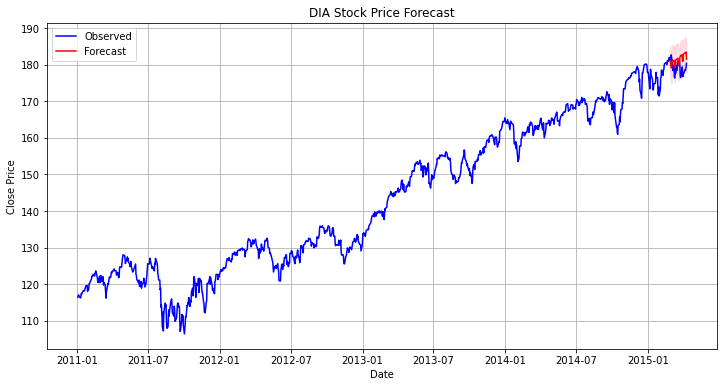

In [53]:
# input_df = dia_df.ticker_data.copy(deep=True)
ticker='DIA'
test_period=30

model = Prophet(changepoint_prior_scale=0.01, seasonality_mode='additive', seasonality_prior_scale=20.0)
data = input_df[[f'Close']].reset_index().copy(deep=True)
data = data.rename(columns={'index': 'ds', f'Close': 'y'})

train_data = data.iloc[0:-test_period]
model.fit(train_data)

future = model.make_future_dataframe(periods=test_period)
forecast = model.predict(future)

# Preparing data
observed_data = data.copy()
observed_data['ds'] = pd.to_datetime(data['ds'])  # Convert to datetime format

# Extracting forecasted data
forecasted_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

forecasted_data = forecasted_data[forecasted_data['ds']>train_data['ds'].max()]
forecasted_data['ds']= pd.to_datetime(data.iloc[-test_period:]['ds'])
forecasted_data


# Plotting the observed data
plt.figure(figsize=(12, 6))
plt.plot(observed_data['ds'], observed_data['y'], label='Observed', color='blue')

# Plotting the forecasted data
plt.plot(forecasted_data['ds'], forecasted_data['yhat'], label='Forecast', color='red')

# Plotting the uncertainty intervals
plt.fill_between(forecasted_data['ds'], forecasted_data['yhat_lower'], forecasted_data['yhat_upper'], color='pink', alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{ticker} Stock Price Forecast')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [54]:
import math 
from sklearn.metrics import mean_absolute_error


def rmse(predictions, targets):
    error = 0
    for i in range(len(predictions)):
        error += (predictions[i] - targets[i]) ** 2
    mse = error / len(predictions)
    rmse = math.sqrt(mse)
    return rmse


In [55]:
# forecast = model.predict(test.drop(columns='y'))
# mae_baseline = mean_absolute_error(test['y'], forecast['yhat'])
# print(f"Baseline Mean Absolute Error: {mae_baseline}")


In [56]:
future.min(), future.max()

(ds   2011-01-03
 dtype: datetime64[ns],
 ds   2015-03-28
 dtype: datetime64[ns])

In [57]:
min_date, max_date = forecast['ds'].min(), forecast['ds'].max()
min_date, max_date

(Timestamp('2011-01-03 00:00:00'), Timestamp('2015-03-28 00:00:00'))

In [58]:
min_date, max_date  = dia_df.ticker_data.index.min(), dia_df.ticker_data.index.max()
min_date, max_date 

(0, 1073)

In [59]:
joined_df = pd.merge(forecast.iloc[-test_period:], dia_df.ticker_data, how='inner', left_on=forecast['ds'].iloc[-test_period:].astype(str), right_on=dia_df.ticker_data.index)
joined_df = joined_df[['ds', 'yhat', 'Close']]

joined_df.sort_values(by='ds', ascending=True, inplace=True)

plt.figure(figsize=(20,10))

plt.plot(pd.to_datetime(dia_df.ticker_data.index), dia_df.ticker_data['Close'], label='Actual Closing Price')
plt.plot(joined_df['ds'], joined_df['yhat'], label='yhat')
plt.plot(joined_df['ds'], joined_df['Close'], label='Close')

plt.title("Forecasted Prices for DIA using Prophet", fontsize=20)
plt.ylabel("Closing Price ($)")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.legend()

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [ ]:
rmses = []
maes = []
for N in range(1,len(joined_df['yhat'])): 
    rmses.append(rmse(joined_df['yhat'].iloc[0:N], joined_df['Close'].iloc[0:N]))
    maes.append(mean_absolute_error(joined_df['yhat'].iloc[0:N], joined_df['Close'].iloc[0:N]))
plt.plot(rmses, label='rmse') 
plt.plot(maes, label='mean absolute error')    

plt.xlabel("Days Out")
plt.ylabel("RMSE")
plt.title("RMSE by Days Out")
plt.legend()

In [ ]:
joined_df['rmse']= rmse(joined_df['yhat'], joined_df['Close'])
joined_df

In [60]:
dia_df.ticker_data[dia_df.ticker_data.index>=str(min_date)]

TypeError: Invalid comparison between dtype=int64 and str

In [61]:
dia_df.ticker_data

,index,Open,High,Low,Close,Volume,ticker,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
0,2011-01-03,116.410004,116.860001,116.360001,116.410004,9108900,DIA,NaN,0.000000,0.131682,0.131682,0.000000,0.000000,-0.426358,4.152463,804.160704,2.391784e-175
1,2011-01-04,116.709999,116.730003,116.110001,116.639999,9775600,DIA,0.001976,0.197574,0.134696,0.133189,0.000002,0.001507,-0.426358,4.152463,804.160704,2.391784e-175
2,2011-01-05,116.459999,117.190002,116.300003,117.040001,7567800,DIA,0.003429,0.541188,0.139937,0.135439,0.000012,0.003411,-0.426358,4.152463,804.160704,2.391784e-175
3,2011-01-06,117.139999,117.190002,116.500000,116.779999,7161600,DIA,-0.002221,0.317838,0.136530,0.135711,0.000009,0.002991,-0.426358,4.152463,804.160704,2.391784e-175
4,2011-01-07,116.910004,117.099998,115.820000,116.570000,9249800,DIA,-0.001798,0.137442,0.133779,0.135325,0.000008,0.002785,-0.426358,4.152463,804.160704,2.391784e-175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,2015-04-06,176.320007,179.169998,176.089996,178.589996,6284900,DIA,0.007105,53.414647,0.946410,0.490137,0.073307,0.270753,-0.426358,4.152463,804.160704,2.391784e-175
1070,2015-04-07,178.770004,179.580002,178.419998,178.419998,6011600,DIA,-0.000952,53.268613,0.944182,0.490561,0.073431,0.270982,-0.426358,4.152463,804.160704,2.391784e-175
1071,2015-04-08,178.600006,179.559998,177.960007,178.750000,4738500,DIA,0.001850,53.552096,0.948506,0.490988,0.073558,0.271216,-0.426358,4.152463,804.160704,2.391784e-175
1072,2015-04-09,178.660004,179.630005,177.979996,179.399994,4483800,DIA,0.003636,54.110462,0.957023,0.491422,0.073692,0.271462,-0.426358,4.152463,804.160704,2.391784e-175


In [62]:
# y_true= dia_df.ticker_data.iloc[-test_period:]['Close']
# y_pred = forecast['yhat']

# rmse(y_pred, y_true)

In [63]:
# len(y_true), len(y_pred)

In [64]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f"Best parameters: {best_params}")


Best parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20.0}


In [65]:
plot_prediction(dia_df, ticker='DIA', test_period=30)

ParserError: day is out of range for month: 0

In [ ]:
ph.plot_prediction(qqq_df, ticker='QQQ', test_period=30)

In [ ]:
ph.plot_prediction(spy_df, ticker='SPY', test_period=30)

### Optimal Portfolio Weights over Time 

In [ ]:

min_weight = 0.05
max_weight = 0.95


# Annual risk-free rate
annual_risk_free_rate = 0.02
# Convert annual risk-free rate to daily rate
daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1


unique_dates = list(set(merged_df.index))
unique_dates.sort()

moving_optimal_weights = []

for N in range(2,len(unique_dates)): 
    DIA = list(dia_df.ticker_data['pct_change'].iloc[1:N])
    QQQ = list(qqq_df.ticker_data['pct_change'].iloc[1:N])
    SPY = list(spy_df.ticker_data['pct_change'].iloc[1:N])

    # Calculate mean returns and covariance matrix

    returns = np.array([DIA, QQQ, SPY])
    mean_returns = np.mean(returns, axis=1)

    cov_matrix = np.cov(returns)
       
    # Perform optimization
    num_stocks = len(mean_returns)
    optimal_weights = opt.maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate, num_stocks, min_weight, max_weight)

    moving_optimal_weights.append(optimal_weights.x)

area_plot = plot.create_area_plot(moving_optimal_weights, tickers, unique_dates)
area_plot.show()



In [ ]:
plot.plot_column_across_tickers(df, col_name = 'Cumulative_Percentage_Change', title='Cumulative Percentage Change of Closing Price', xaxis_title='Trading Date', yaxis_title='Cumulative % increase')

In [ ]:
df['Close'].iloc[1:10].values

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima


In [ ]:
stock_prices = df['Close'].iloc[1:100].values

date_range = pd.date_range(start='2023-04-01', periods=len(stock_prices), freq='D')
stock_data = pd.Series(stock_prices, index=date_range)


In [66]:
stock_data.plot(title="Daily Closing Prices")
plt.show()


NameError: name 'stock_data' is not defined

In [67]:
adf_test = adfuller(stock_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


NameError: name 'adfuller' is not defined

ADF Statistic after differencing: The ADF statistic is now -8.1971, which is a much more negative value compared to the ADF statistic before differencing (-2.3125). This indicates stronger evidence against the null hypothesis (i.e., the series is likely stationary).

p-value after differencing: The p-value after differencing is 7.3983e-13, which is a very small value, much smaller than the common significance level of 0.05. This suggests strong evidence against the null hypothesis, meaning that the time series is likely stationary after differencing.

With the p-value being significantly smaller than the chosen significance level, you can reject the null hypothesis and conclude that the differenced time series is stationary. This stationary series can now be used for further analysis and fitting an ARIMA model.






In [68]:
stock_data_diff = stock_data.diff().dropna()
adf_test_diff = adfuller(stock_data_diff)
print(f"ADF Statistic after differencing: {adf_test_diff[0]}")
print(f"p-value after differencing: {adf_test_diff[1]}")


NameError: name 'stock_data' is not defined

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stock_data_diff, ax=axes[0])
plot_pacf(stock_data_diff, ax=axes[1])
plt.show()


In [69]:
model = auto_arima(stock_data, seasonal=False, stepwise=True,
                   suppress_warnings=True,
                   information_criterion='aic',
                   trace=True)


NameError: name 'auto_arima' is not defined

The result Best ARIMA Model: (0, 1, 0) represents the optimal ARIMA model with the order (p, d, q). In this case, p (autoregressive component) is 0, d (differencing component) is 1, and q (moving average component) is 0.

To interpret this in terms of how many previous days matter, you need to consider the p (AR) and q (MA) components:

p (AR component): Since p is 0, there is no significant relationship between the current observation and any of the previous observations (lags) in the autoregressive part of the model. In other words, no previous day's closing price has a direct impact on the current day's closing price.

q (MA component): Since q is 0, there is no significant relationship between the current observation and the residual errors from previous observations in the moving average part of the model. This means that no previous day's residual error has a direct impact on the current day's closing price.

In this specific case, with an ARIMA(0, 1, 0) model, you can conclude that none of the previous days matter directly. The model simply suggests that the closing price's best prediction is its previous day's value, plus a constant (i.e., a random walk with drift). It's important to note that the small sample size might have affected the results, and it's always better to work with a larger dataset for more reliable results.

In [70]:
print(f"Best ARIMA Model: {model.order}")


AttributeError: 'Prophet' object has no attribute 'order'

In [36]:
# !pip install tensorflow

In [37]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - look_back - 1):
#         dataX.append(dataset[i:(i + look_back), 0])
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

# # Load and preprocess the data
# # Replace 'your_data.csv' with the file containing your historical EUR/USD exchange rate data
# data = df['Close'].iloc[1:500].values
# data = data['EUR/USD'].values.reshape(-1, 1)

# # Normalize the data
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

# # Split the data into training and testing sets
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# look_back = 3
# X_train, y_train = create_dataset(train, look_back)
# X_test, y_test = create_dataset(test, look_back)

# # Reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# # Create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# # Make predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Invert predictions
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform([y_train])
# test_predict = scaler.inverse_transform(test_predict)
# y_test = scaler.inverse_transform([y_test])

# # Calculate root mean squared error
# train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
# print('Train Score: %.2f RMSE' % train_score)
# test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
# print('Test Score: %.2f RMSE' % test_score)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class PsiActivation(Layer):
    def __init__(self, sigma=1.0, **kwargs):
        super(PsiActivation, self).__init__(**kwargs)
        self.sigma = sigma

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="psi_sigma",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(self.sigma),
            trainable=True,
        )
        super(PsiActivation, self).build(input_shape)

    def call(self, x):
        return 1 / (1 + K.exp(-self.kernel * x))

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {"sigma": self.sigma}
        base_config = super(PsiActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
